## Trabajo final para la materia Vision Por Computadora 2 - Trashnet
Clasificación de residuos para reciclaje: Entrenar un modelo que, a partir de imágenes, clasifique distintos tipos de residuos (plástico, vidrio, papel, orgánicos) para optimizar procesos de reciclaje y gestión de residuos.​


Grupo: 
  - Martin Brocca
  - Emliano Iparraguirre

## 1 Análisis Exploratorio de Datos

In [6]:

import numpy as np
import os

In [7]:
# analisis de datos, cantidad de clases y cantidad de imagenes por clase
#contar la cantidad de archivos en cada carpeta
data_dir = 'data/trashnet'
classes = os.listdir(data_dir)
class_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))
print(class_counts)

{'paper': 594, 'metal': 410, 'cardboard': 403, 'trash': 137, 'glass': 501, 'plastic': 482}


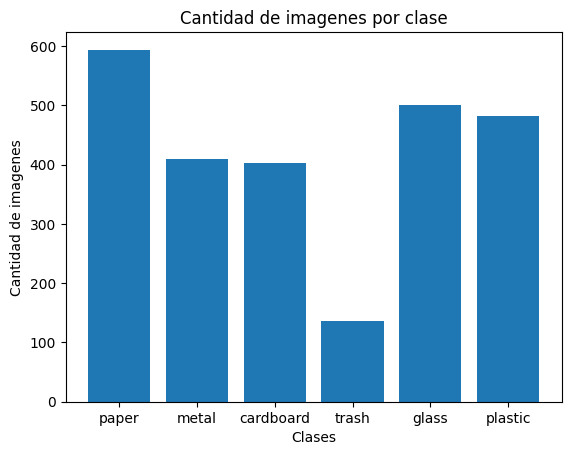

In [9]:
#visualizar en un histograma la cantidad de imagenes por clase
import matplotlib.pyplot as plt
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Clases')
plt.ylabel('Cantidad de imagenes')
plt.title('Cantidad de imagenes por clase')
plt.show()

### Hay un claro desbalance de clases, con "trash" siendo la clase minoritaria


In [10]:
#analisis de tamaño de las imagenes
image_sizes = []
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            image_sizes.append(img.shape)  
image_sizes = np.array(image_sizes)
print(f'Tamaño minimo: {image_sizes.min(axis=0)}')
print(f'Tamaño maximo: {image_sizes.max(axis=0)}')
print(f'Tamaño promedio: {image_sizes.mean(axis=0)}')


Tamaño minimo: [384 512   3]
Tamaño maximo: [384 512   3]
Tamaño promedio: [384. 512.   3.]


### Todas las imágenes tienen el mismo tamaño, y están en RGB

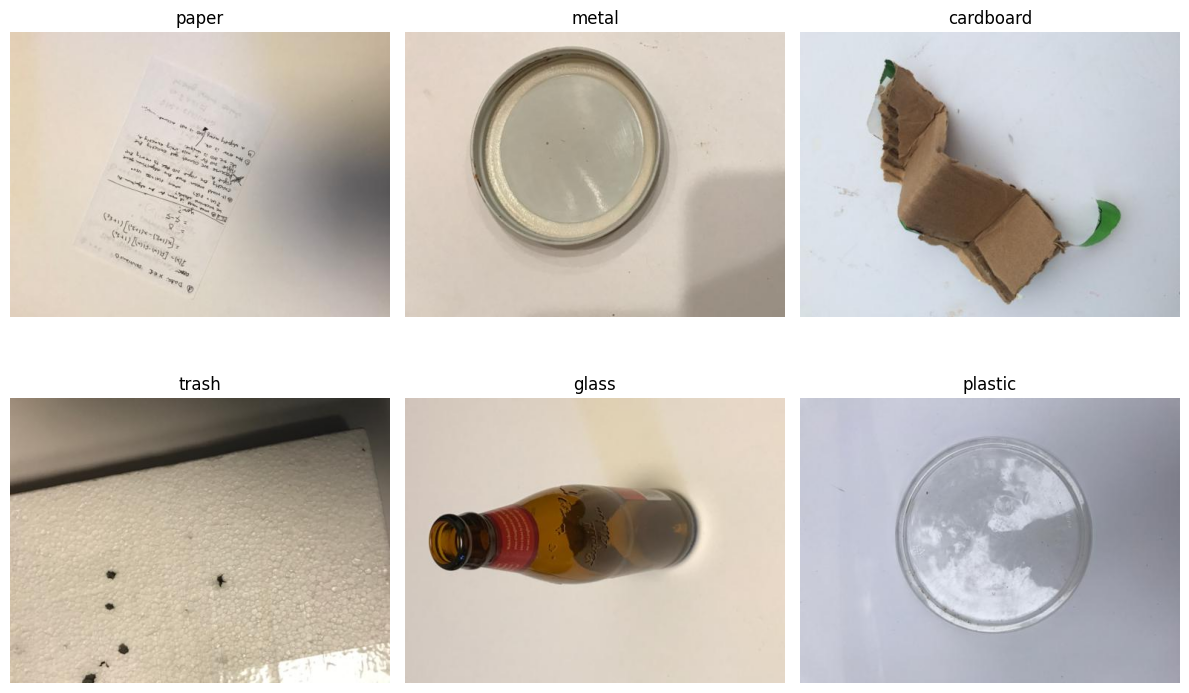

In [11]:
#previsualizar algunas imagenes de cada clase
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, cls in zip(axes.flatten(), classes):
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        img_name = np.random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(cls)
        ax.axis('off')
plt.tight_layout()
plt.show()
